In [ ]:
!rm -rf /content/dataset

In [ ]:
!rm -rf /content/__MACOSX

In [ ]:
!mkdir -p /content/dataset

In [ ]:
!rm /content/final_data_v2.zip

In [ ]:
# @title 1. Setup, Extract & Feature Engineering
import os
import zipfile
import shutil
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from PIL import Image

# --- CONFIGURATION ---
zip_path = '/content/final_data.zip'
extract_path = '/content/dataset'
data_dir = os.path.join(extract_path, 'final_data')

# 1. CLEAN & EXTRACT
if os.path.exists(extract_path):
    shutil.rmtree(extract_path)

print(f"📂 Extracting {zip_path}...")
try:
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)

    if not os.path.exists(data_dir):
        if 'final_data' in os.listdir(extract_path):
             data_dir = os.path.join(extract_path, 'final_data')
        else:
             data_dir = extract_path

    print(f"✅ Data extracted to: {data_dir}")

except Exception as e:
    print(f"❌ Error: {e}")

# 2. FEATURE ENGINEERING
print("\n⚙️ Configuring Augmentation...")

# [HYPERPARAMETER] Augmentation Strength
# We distort training images so the model learns to ignore lighting/orientation
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Clean transform for Validation/Test (No distortion, just resize)
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

📂 Extracting /content/final_data.zip...
✅ Data extracted to: /content/dataset

⚙️ Configuring Augmentation...


In [ ]:
# @title 2. Data Selection & Splitting (80/10/10 Split)
print("📊 Loading and Splitting Data...")

try:
  # ADD THIS NEW LINE HERE:
    data_dir = '/content/dataset/final_data_v2'
    # 1. Load Full Dataset
    full_dataset = datasets.ImageFolder(root=data_dir, transform=train_transform)
    total_count = len(full_dataset)

    # 2. Calculate Sizes (80% / 10% / 10%)
    # [HYPERPARAMETER] Split Ratio
    train_size = int(0.8 * total_count)
    val_size = int(0.1 * total_count)
    test_size = total_count - train_size - val_size

    # 3. Perform Random Split
    train_dataset, val_dataset, test_dataset = random_split(
        full_dataset, [train_size, val_size, test_size]
    )

    # 4. Apply "Clean" Transform to Val and Test
    val_dataset.dataset.transform = val_transform
    test_dataset.dataset.transform = val_transform

    # 5. Create Loaders
    # [HYPERPARAMETER] Batch Size (default 16)
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

    print(f"✅ Success! Total Images: {total_count}")
    print(f"   - Training Set:   {train_size} (80%)")
    print(f"   - Validation Set: {val_size} (10%) -> Used for Tuning")
    print(f"   - Test Set:       {test_size} (10%) -> Used for Final Metrics")

except Exception as e:
    print(f"❌ Error: {e}")

📊 Loading and Splitting Data...
✅ Success! Total Images: 1668
   - Training Set:   1334 (80%)
   - Validation Set: 166 (10%) -> Used for Tuning
   - Test Set:       168 (10%) -> Used for Final Metrics


In [ ]:
# @title Clean Hidden Mac Files
import os
import shutil

print("🧹 Cleaning dataset...")

# 1. Delete the __MACOSX folder specifically
macosx_path = '/content/dataset/__MACOSX'
if os.path.exists(macosx_path):
    shutil.rmtree(macosx_path)
    print("✅ Removed '__MACOSX' folder.")
else:
    print("ℹ️ '__MACOSX' folder not found (already clean).")

# 2. Delete any separate "ghost" files starting with ._
# (Sometimes these hide inside your real Normal/Defect folders)
count = 0
for root, dirs, files in os.walk('/content/dataset'):
    for file in files:
        if file.startswith('._'):
            os.remove(os.path.join(root, file))
            count += 1

print(f"✅ Deleted {count} hidden metadata files.")
print("🎉 Dataset is clean!")

🧹 Cleaning dataset...
✅ Removed '__MACOSX' folder.
✅ Deleted 0 hidden metadata files.
🎉 Dataset is clean!


🧠 Initializing ResNet-50...

🚀 Starting Training...
   Epoch 1/15 | Val Acc: 86.14%
   Epoch 2/15 | Val Acc: 90.96%
   Epoch 3/15 | Val Acc: 89.16%
   Epoch 4/15 | Val Acc: 90.96%
   Epoch 5/15 | Val Acc: 95.78%
   Epoch 6/15 | Val Acc: 87.35%
   Epoch 7/15 | Val Acc: 93.37%
   Epoch 8/15 | Val Acc: 93.37%
🛑 Early stopping at epoch 8


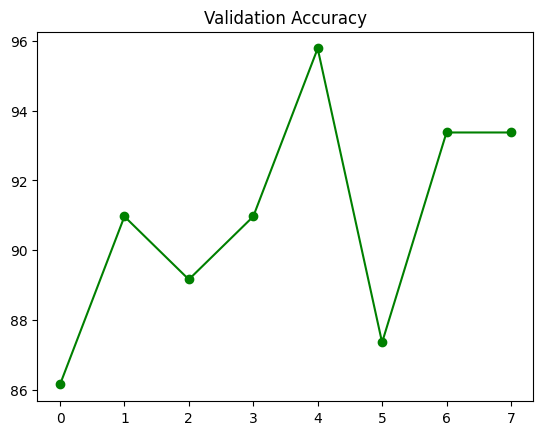

In [ ]:
# @title 3. Model Training (with Hyperparameters)
import torch.nn as nn
import torch.optim as optim
from torchvision import models
import time
import copy
import matplotlib.pyplot as plt

print("🧠 Initializing ResNet-50...")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet50(weights='IMAGENET1K_V1')

# Freeze the "Brain" (Feature Extractor)
for param in model.parameters():
    param.requires_grad = False

# Replace the "Head" (Classifier)
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 256),
    nn.ReLU(),
    nn.Dropout(0.4), # [HYPERPARAMETER] Dropout Rate
    nn.Linear(256, 2)
)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
# [HYPERPARAMETER] Learning Rate
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

# [HYPERPARAMETER] Epochs & Patience
epochs = 15
patience = 3

best_acc = 0.0
best_model_wts = copy.deepcopy(model.state_dict())
history = {'acc': [], 'loss': []}
patience_counter = 0

print(f"\n🚀 Starting Training...")
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Check accuracy on Validation Set (The "Practice Quiz")
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    epoch_acc = 100 * correct / total
    history['acc'].append(epoch_acc)
    print(f"   Epoch {epoch+1}/{epochs} | Val Acc: {epoch_acc:.2f}%")

    # Save model if it's the best one so far
    if epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model_wts = copy.deepcopy(model.state_dict())
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"🛑 Early stopping at epoch {epoch+1}")
            break

# Load the best model for the final test
model.load_state_dict(best_model_wts)
plt.plot(history['acc'], marker='o', color='green'); plt.title("Validation Accuracy"); plt.show()

📸 Automatically selecting 8 random images from the Test Set (Unseen Data)...


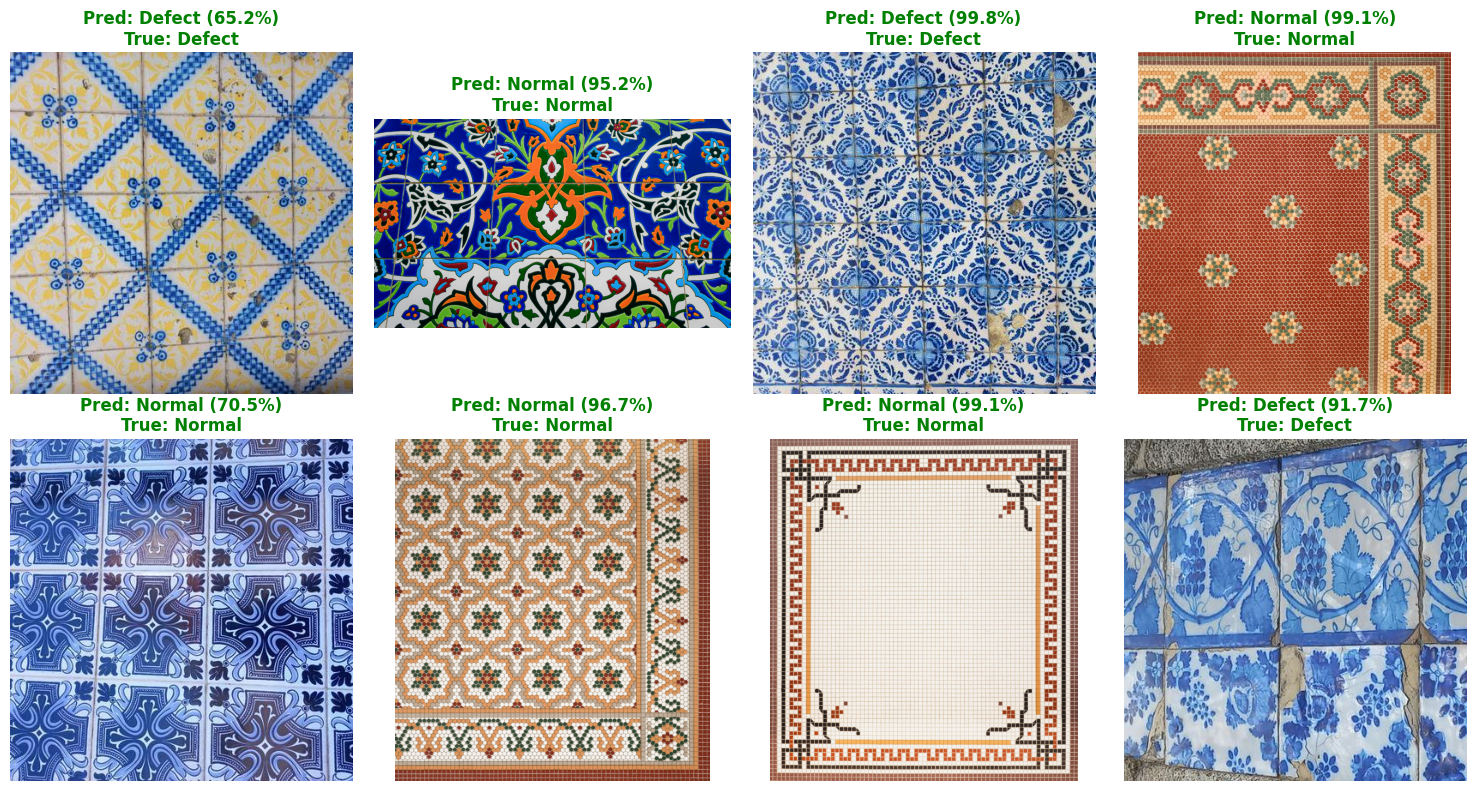

✅ This grid shows how the model performed on data it never saw during training.


In [ ]:
# @title 4. Qualitative Analysis (Automatic from Test Set)
import random
import math
import matplotlib.pyplot as plt

print("📸 Automatically selecting 8 random images from the Test Set (Unseen Data)...")

num_samples = 8
# We pick random images from the Test Set
random_indices = random.sample(range(len(test_dataset)), num_samples)

cols = 4
rows = math.ceil(num_samples / cols)
plt.figure(figsize=(15, 4 * rows))

model.eval()

for i, idx in enumerate(random_indices):
    # Get the image and the True Label from the dataset
    original_idx = test_dataset.indices[idx]
    image_path, label_idx = full_dataset.samples[original_idx]

    image = Image.open(image_path).convert('RGB')
    input_tensor = val_transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(input_tensor)
        probs = torch.nn.functional.softmax(outputs, dim=1)
        confidence, predicted_class = torch.max(probs, 1)

        classes = full_dataset.classes
        prediction = classes[predicted_class.item()]
        score = confidence.item() * 100
        ground_truth = classes[label_idx] # This is how we know if it's correct!

    ax = plt.subplot(rows, cols, i + 1)
    ax.imshow(image)
    ax.axis('off')

    # Green title = Correct, Red title = Wrong
    color = 'green' if prediction == ground_truth else 'red'
    ax.set_title(f"Pred: {prediction} ({score:.1f}%)\nTrue: {ground_truth}",
                 color=color, fontweight='bold')

plt.tight_layout()
plt.show()
print("✅ This grid shows how the model performed on data it never saw during training.")

📊 Running Final Exam on Test Set (10% Split)...

FINAL TEST REPORT (80/10/10 Split)
              precision    recall  f1-score   support

      Defect       0.95      0.97      0.96        93
      Normal       0.96      0.93      0.95        75

    accuracy                           0.95       168
   macro avg       0.95      0.95      0.95       168
weighted avg       0.95      0.95      0.95       168



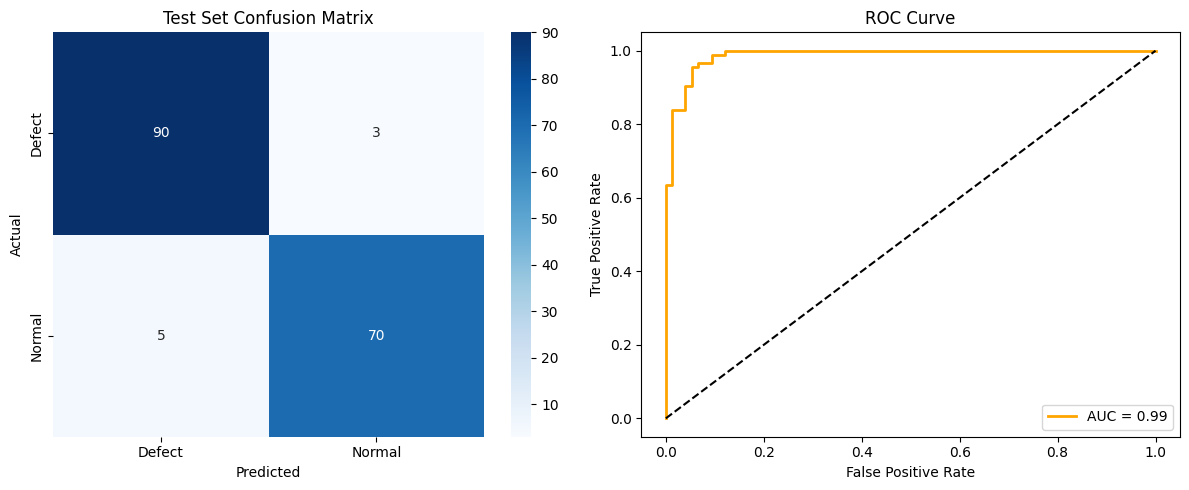

🏆 Final Test AUC Score: 0.9878


In [ ]:
# @title 5. Final Test Evaluation (Metrics on Test Split)
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt

print("📊 Running Final Exam on Test Set (10% Split)...")

y_true = []
y_pred = []
y_probs = []

model.eval()
with torch.no_grad():
    # IMPORTANT: We iterate over test_loader now!
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to('cpu').numpy()

        outputs = model(inputs)
        probs = torch.nn.functional.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs, 1)

        y_true.extend(labels)
        y_pred.extend(predicted.cpu().numpy())
        y_probs.extend(probs[:, 0].cpu().numpy())

class_names = full_dataset.classes

# 1. Classification Report
print("\n" + "="*50)
print("FINAL TEST REPORT (80/10/10 Split)")
print("="*50)
print(classification_report(y_true, y_pred, target_names=class_names))

# 2. Confusion Matrix & ROC
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Test Set Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')

y_true_binary = [1 if x == 0 else 0 for x in y_true]
fpr, tpr, _ = roc_curve(y_true_binary, y_probs)
roc_auc = auc(fpr, tpr)

plt.subplot(1, 2, 2)
plt.plot(fpr, tpr, color='orange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.tight_layout()
plt.show()

print(f"🏆 Final Test AUC Score: {roc_auc:.4f}")

In [ ]:
# @title 6. Launch Gradio App (Manual Upload)
!pip install gradio -q
import gradio as gr

def predict_user_image(image):
    if image is None: return None
    image_tensor = val_transform(image).unsqueeze(0).to(device)
    model.eval()
    with torch.no_grad():
        outputs = model(image_tensor)
        probs = torch.nn.functional.softmax(outputs, dim=1)[0]
        # Return probability for both classes
        return {full_dataset.classes[i]: float(probs[i]) for i in range(2)}

interface = gr.Interface(
    fn=predict_user_image,
    inputs=gr.Image(type="pil", label="Upload Your Tile Image"),
    outputs=gr.Label(num_top_classes=2, label="AI Assessment"),
    title="Wall/Floor Tile Defect Inspector",
    description="Drop a tile image here to check for defects manually."
)

interface.launch(share=True, debug=True)

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://ea3140cb32df6a533d.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


ERROR:    Exception in ASGI application
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/uvicorn/protocols/http/httptools_impl.py", line 416, in run_asgi
    result = await app(  # type: ignore[func-returns-value]
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/uvicorn/middleware/proxy_headers.py", line 60, in __call__
    return await self.app(scope, receive, send)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/fastapi/applications.py", line 1139, in __call__
    await super().__call__(scope, receive, send)
  File "/usr/local/lib/python3.12/dist-packages/starlette/applications.py", line 107, in __call__
    await self.middleware_stack(scope, receive, send)
  File "/usr/local/lib/python3.12/dist-packages/starlette/middleware/errors.py", line 186, in __call__
    raise exc
  File "/usr/local/lib/python3.12/dist-packages/starlette/middleware/error

Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://ea3140cb32df6a533d.gradio.live
